# Taller II: Implementing a simple ASR system using HMM

En este taller implementaremos un sistema de reconocimiento automatico de habla, utilizando modelos ocultos de markov. Para este taller se puede utilizar la libreria [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/tutorial.html#customizing) de Python. Este taller será parte de la nota del proyecto de evaluación del primer corte. Así que se deberá entregar al finalizar la semana 5 junto con el desarrollo del proyecto de evaluación.

En este taller implementaremos un sistema de reconocimiento de habla de palabras aisladas. Esto quiere decir que hay una separación entre cada palabra pronunciada, y no se utilizará  habla fluida continua. La idea es implementar un sistema sencillo con un vocabulario limitado, para qu epuedan entender el principio de funcionamiento de estos sistemas. Para este taller deben seguir lso siguientes pasos:

1. Cree un diccionaro pequeño compuesto de alrededor de 20 palabras. Si desean incluir más palabras no hay problema.
2. Cada una de estas palabras dividalas en fonemas. Asigne a cada fonema un número para facilitar su identificación.
3. Grabé cada una de las palbaras de forma aislada. 
4. Para cada señal de voz grabada calcule el mel espectrograma utilizando 39 componentes (este es el estandar que usan los sistemas modernos).
5. Identifique las secciones del mel spectrograma que corresponden a cada fonema.
6. Modele la distribución de los vectores del Mel espectrograma para cada fonema, esto puede hacerlo usando GMM (Gaussian Mixture Models).
7. Calcule la matrix de probabilidades de transición utilizando el diccionario que ustedes crearón.
8. Implemente el modelo HMM.
9. Pruebe con los datos de entrenamiento si el modelo produce la secuencia de fonemas indicada.
10. Genere un nuevo conjunto de palabras (al menos 10) que se conformen con los fonemas presentes en su diccionario. A partir de la señal de voz de cada una de estas nuevas palabras, trate de predecir la palbara escrita utilizando el modelo implementado.

**NOTA:** Trate de Utilizar fonemas que tengan una única relación con letras (silabas) del alfabeto. Esto disminuirá la tasa de error del modelo.

## Desarrollo

#### Sergio Nicolás Duque Báez 
#### Víctor Samuel Pérez Díaz

In [1]:
# Estas librerias fueron importadas en python 3.8.5. En 3.9 hay problemas.

import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

from librosa import mel_frequencies
from librosa.feature import melspectrogram
from librosa.display import specshow
from scipy.io.wavfile import write
from scipy import signal as sig
from scipy import ndimage as nd



---
## 1.

In [2]:
dic = ['aspa', 'abeja', 'mama', 'mapa', 'avispa', 'oveja', 'beso', 'peso', 'pata', 'cabo', 'capo', 'escarbar', 'escapar', 'borra', 
'gorra', 'ancla', 'vista', 'pista', 'papa', 'pasta', 'grama', 'bomba']

---
## 2.

In [3]:
phonems = ['a', 's', 'p', 'b', 'e', 'j', 'm', 'v', 'i', 'o', 'v', 't', 'c', 'r', 'rr', 'g', 'n', 'l']

phonems.sort()

---
## 3.

In [ ]:
############## JUST RUN FOR RECORDING ##############
############## JUST RUN FOR RECORDING ##############
############## JUST RUN FOR RECORDING ##############
############## IR AL SIGUIENTE PASO   ##############

# Setting the interfaz to acquire de audio data
fs = 8000  # Sample rate
seconds = 2  # Duration of recording

n=1
for word in dic:
    
    myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=1, dtype='int16')

    # Acquiring audio data
    print('Start speaking: ' + 'audios/{}_{}.wav'.format(word, n))
    sd.wait()  # Wait until recording is finished
    print('End of Recording.')
    
    write('audios/{}_{}.wav'.format(word, n), fs, myrecording)  # Save as WAV file

In [51]:
# Extracting audio
name = dic[0]
y, fs = sf.read('audios1/{}1.wav'.format(name))
y = y/np.std(y)
sd.play(y, fs)

if len(y.shape) > 1:
    y = y[:,0]
    
# Normalize

#y = (y-y.min())/(y.max()-y.min())

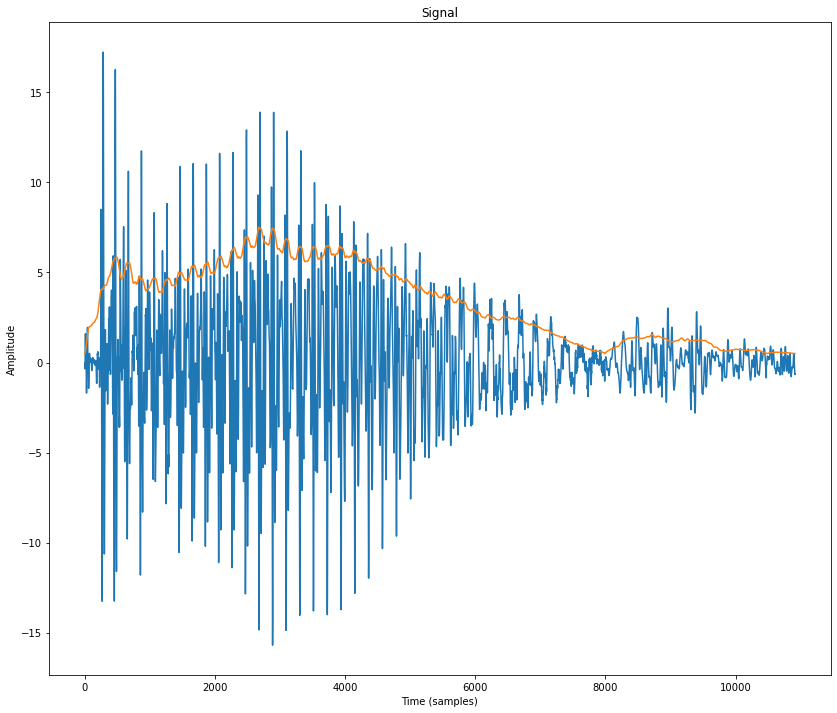

In [52]:
env = np.abs(sig.hilbert(y))
env = nd.uniform_filter1d(env, 500)

env_mask = env > 0.5
plt.figure(figsize=(14,12))
plt.plot(y[env_mask]);
plt.plot(env[env_mask])
plt.title('Signal');
plt.xlabel('Time (samples)');
plt.ylabel('Amplitude');

---
## 4.

In [53]:
# Computing
len_win = int(np.fix(0.02*fs)) # Defining the samples for a 20ms window
window = np.hanning(len_win) # Computing the window length to compute the spectrogram
len_over = int(np.fix(0.01*fs)) # Defining number of samples for an overlap of 10ms between consecutive windows
#nfft = 512 # Number of points for the FFT

In [54]:
# Computing the Mel-Spectrogram
n_coeff = 39

Sm = melspectrogram(y=y[env_mask], sr=fs, window = window, win_length = len_win, hop_length=len_over, n_mels = n_coeff)
fm = mel_frequencies(n_mels=n_coeff, fmin=20, fmax=fs/2, htk=False)

# _NOTA: Preguntar a Alex sobre NFFT._

C:\Users\samue\miniconda3\envs\nlp\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\samue\miniconda3\envs\nlp\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


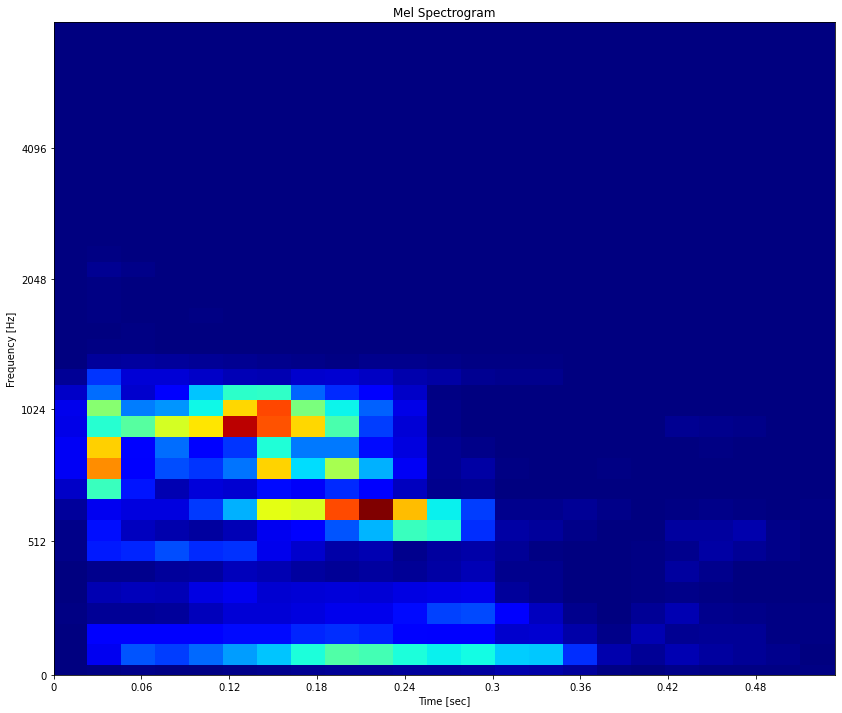

In [55]:
plt.figure(figsize=(14,12))
specshow(Sm, y_axis='mel', fmax=8000, x_axis='time', cmap='jet');
plt.title('Mel Spectrogram');
plt.ylabel('Frequency [Hz]');
plt.xlabel('Time [sec]');

In [60]:
def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    return out

In [66]:
Sm_split = chunkIt(Sm, 4);